In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchmetrics.detection import MeanAveragePrecision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
import time
from pprint import pprint

In [2]:
# Set random seed for reproducibility
manualSeed = 99
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  99


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Preprocessing

Before starting, make sure to:
1. name the root_folder
2. Rename img_root/Bicycle/2015_00391.JPG to ExDark/Bicycle/2015_00391.jpg (since ExDarkAnnotation is called 2015_00391.jpg.txt)
3. Remove img_root/Bicycle/.ipynb_checkpoints
4. Remove img_root/Motorbike/2015_05894.jpg (since ExDarkAnnotation/Motorbike/2015_05894.jpg.txt has no box coordinates)
5. dog/2015_05590.jpg was moved to a different folder for testing results

In [4]:
#folder containing dataset to train/test on
root_folder = 'ExDarkEG'

#optimizer to use. Either Adam or SGD
optim = 'PRETRAIN'

In [5]:
#go through every file and make sure the images have the same name format as their annotation counterpart.
img_root = './{}'.format(root_folder) #all images should be stored in this folder

#create directory to store saved models
if not os.path.exists('./torchsaves'):
    os.mkdir('./torchsaves')

if not os.path.exists('./torchsaves/losses'):
    os.mkdir('./torchsaves/losses')
    
#create directory to store models during training
modelsaves = './torchsaves/{}_{}'.format(root_folder,optim)
if not os.path.exists(modelsaves):
    os.mkdir(modelsaves)
    print('created {}...'.format(modelsaves))
    
#check 2
img1 = '{}/Bicycle/2015_00391.JPG'.format(img_root)
if os.path.exists(img1):
    os.rename(img1,'{}/Bicycle/2015_00391.jpg'.format(img_root))

#check 3
if os.path.exists('{}/Bicycle/.ipynb_checkpoints'.format(img_root)):
    os.rmdir('{}/Bicycle/.ipynb_checkpoints'.format(img_root))
    
if os.path.exists('{}/Dog/.ipynb_checkpoints'.format(img_root)):
    os.rmdir('{}/Dog/.ipynb_checkpoints'.format(img_root))

#check 4
img3 = '{}/Motorbike/2015_05894.jpg'.format(img_root)
if os.path.exists(img3):
    os.remove('{}/Motorbike/2015_05894.jpg'.format(img_root))
if os.path.exists('./ExDarkAnnotation/Motorbike/2015_05894.jpg.txt'):
    os.remove('./ExDarkAnnotation/Motorbike/2015_05894.jpg.txt')

#check for any bad files we may have missed
for classname in os.listdir(img_root):
    if classname == '__MACOSX':
        print(' --- please remove __MACOSX folder!!! ---')
        continue
    labelpath = os.path.join('./ExDarkAnnotation',classname)
    imagepath = os.path.join(img_root,classname)
    print('checking imagepath: {} ~ labelpath: {}'.format(imagepath,labelpath))
    for img_name in os.listdir(imagepath):
        if img_name[0] != '2':
            print('{} at {}'.format(img_name,imagepath))
        lblpath = os.path.join(labelpath,img_name+'.txt')
        if not os.path.exists(lblpath):
            print('img path: {}'.format(img_name))

created ./torchsaves/ExDarkEG_PRETRAIN...
checking imagepath: ./ExDarkEG/Cup ~ labelpath: ./ExDarkAnnotation/Cup
checking imagepath: ./ExDarkEG/Car ~ labelpath: ./ExDarkAnnotation/Car
checking imagepath: ./ExDarkEG/Bottle ~ labelpath: ./ExDarkAnnotation/Bottle
checking imagepath: ./ExDarkEG/People ~ labelpath: ./ExDarkAnnotation/People
checking imagepath: ./ExDarkEG/Dog ~ labelpath: ./ExDarkAnnotation/Dog
checking imagepath: ./ExDarkEG/Bus ~ labelpath: ./ExDarkAnnotation/Bus
checking imagepath: ./ExDarkEG/Motorbike ~ labelpath: ./ExDarkAnnotation/Motorbike
checking imagepath: ./ExDarkEG/Chair ~ labelpath: ./ExDarkAnnotation/Chair
checking imagepath: ./ExDarkEG/Bicycle ~ labelpath: ./ExDarkAnnotation/Bicycle
checking imagepath: ./ExDarkEG/Table ~ labelpath: ./ExDarkAnnotation/Table
checking imagepath: ./ExDarkEG/Cat ~ labelpath: ./ExDarkAnnotation/Cat
checking imagepath: ./ExDarkEG/Boat ~ labelpath: ./ExDarkAnnotation/Boat


# Custom Dataset and Model

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir='./ExDark', label_dir='./ExDarkAnnotation', transform=None):
        '''
        Args:
            img_dir: image root directory containing the different class folders ie 'img_dir/class1/image1'
            label_dir: label root directory containing the different class folders ie 'label_dir/class1/label1'
            transform: transforms to apply to the input image
        '''
        self.label_dir = label_dir
        self.img_dir = img_dir
        self.transform = transform
        self.imagelist = [] #list of lists containing [image_name, class_name]
        # example of self.imagelist[12] = ['2015_01863.png', 'Bottle']
        self.class_to_num = {'Bicycle':2,'Boat':9,
                            'People':1,'Bus':6,
                            'Car':3,'Motorbike':4,
                            'Cat':17,'Dog':18,
                            'Bottle':44,'Cup':47,
                            'Chair':62,'Table':67} #maps class name to numeric value ie {'Bottle':1,'Bicycle':2}
        
        #go through each class folder
        for class_name in os.listdir(img_dir):
            classpath = img_dir+'/'+class_name # './img_dir/class_name'
            
            #go through each image in the class folder
            for img in os.listdir(classpath): 
                self.imagelist.append([img, class_name])

    def __len__(self):
        return len(self.imagelist)

    def __getitem__(self, idx):
        '''
        Returns:
            image: (PIL or a torch.Tensor) input image
            target: (dict) label dictionary required for faster R-CNN
        '''
        image_name, class_folder = self.imagelist[idx]
        img_path = os.path.join(self.img_dir,class_folder,image_name)
        target_path = os.path.join(self.label_dir,class_folder,image_name+'.txt')
        
        image = Image.open(img_path).convert("RGB")
        
        if self.transform is not None:
            image = self.transform(image)
            image = image.to(dtype=torch.float32)
        
        boxes = []
        labels = []
        with open(target_path,'r') as f:
            for line in f:
                if line[0] == '%':
                    continue
                else:
                    line = line.split()
                    classlabel = line[0]
                    labels.append(self.class_to_num[classlabel])
                    xmin = int(line[1])
                    ymin = int(line[2])
                    xmax = xmin + int(line[3])
                    ymax = ymin + int(line[4])
                    boxes.append([xmin, ymin, xmax, ymax]) #bounding box coords
        
        assert len(boxes) == len(labels)
        
        #turn everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        
        return image, target

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True,trainable_backbone_layers=0)

model.to(device)

model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): ConvNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): Seque

In [8]:
# input_transform = T.Compose([T.PILToTensor()])
input_transform = T.Compose([T.ToTensor()])
dataset = CustomImageDataset(img_dir=img_root,label_dir='./ExDarkAnnotation',transform=input_transform)
dataset_test = CustomImageDataset(img_dir=img_root,label_dir='./ExDarkAnnotation',transform=input_transform)

#split the dataset into train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-1412])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-1412:])

In [9]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [10]:
def get_predicted_boxes(output, score_thresh=0.8):
    '''
    takes in output of model and returns predicted boxes with scores > score_thresh
    
    Args:
        output: a list containing 1 dictionary (model predictions)
    '''
    predicted_list = []
    
    for label_dict in output:
        predicted = {'boxes':[],'labels':[],'scores':[]}
        s = label_dict['scores']
        for i in range(len(s)):
            if s[i] > score_thresh:
                predicted['boxes'].append(label_dict['boxes'][i].tolist())
                predicted['labels'].append(label_dict['labels'][i].tolist())
                predicted['scores'].append(s[i].tolist())
            else:
                #scores should be sorted so we just stop checking after reaching the first elem<0.8
                break
        predicted['boxes'] = torch.tensor(predicted['boxes'])
        predicted['labels'] = torch.tensor(predicted['labels'])
        predicted['scores'] = torch.tensor(predicted['scores'])
        predicted_list.append(predicted)
    return predicted_list

In [11]:
metric = MeanAveragePrecision()

for i in range(len(dataset_test)):
    img, truth = dataset_test[i]
    out = model(img.unsqueeze(dim=0).to(device))
    predictions = get_predicted_boxes(out)
    metric.update(predictions, [truth])

pprint(metric.compute())

/home/cys005/.local/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


{'map': tensor(0.2284),
 'map_50': tensor(0.4401),
 'map_75': tensor(0.2095),
 'map_large': tensor(0.3057),
 'map_medium': tensor(0.0780),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.0118),
 'mar_1': tensor(0.2142),
 'mar_10': tensor(0.2760),
 'mar_100': tensor(0.2760),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.3564),
 'mar_medium': tensor(0.1290),
 'mar_small': tensor(0.0216)}


# Train

GPU out of memory error/ kernel dying with large batch_size.

In [10]:
batch_size = 4
iterations = int(len(dataset)/batch_size) #chose 1412 so we can divide dataset by batch_size=4 evenly
num_epochs = 5

losslist = [] #for graphing losses afterwards
print('Starting training on {} data with {}...\n'.format(root_folder,optim))
for epoch in range(num_epochs):
    print('starting epoch {}'.format(epoch))
    for it in range(iterations):
        if it%200 == 0:
            print('batch {}/{}'.format(it,iterations))
        #get batch data
        #faster r-cnn expects 2 inputs: a list of images and a list of target dictionaries
        images = []
        targets = []
        for b in range(batch_size*it,batch_size*(it+1)):
            img, t = dataset[b]
            images.append(img.to(device))
#             images.append(img)
            t['boxes'] = t['boxes'].to(device) #have to convert the target dictionary to gpu
            t['labels'] = t['labels'].to(device)
            targets.append(t)
            
        #forward pass through model and backprop
        '''
        follows the same logic as train_one_epoch() found here:
        https://github.com/pytorch/vision/blob/main/references/detection/engine.py
        '''
        loss_dict = model(images,targets)
        losses = sum(loss for loss in loss_dict.values())
        if it%100 == 0:
            losslist.append(losses.item())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    torch.save(model.state_dict(),'{}/model_epoch{}.pt'.format(modelsaves,epoch))
    torch.save(optimizer.state_dict(),'{}/optimizer_epoch{}.pt'.format(modelsaves,epoch))

Starting training on ExDarkEG data with SGD...

starting epoch 0
batch 0/1487


/home/cys005/.local/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


batch 200/1487
batch 400/1487
batch 600/1487
batch 800/1487
batch 1000/1487
batch 1200/1487
batch 1400/1487
starting epoch 1
batch 0/1487
batch 200/1487
batch 400/1487
batch 600/1487
batch 800/1487
batch 1000/1487
batch 1200/1487
batch 1400/1487
starting epoch 2
batch 0/1487
batch 200/1487
batch 400/1487
batch 600/1487
batch 800/1487
batch 1000/1487
batch 1200/1487
batch 1400/1487
starting epoch 3
batch 0/1487
batch 200/1487
batch 400/1487
batch 600/1487
batch 800/1487
batch 1000/1487
batch 1200/1487
batch 1400/1487
starting epoch 4
batch 0/1487
batch 200/1487
batch 400/1487
batch 600/1487
batch 800/1487
batch 1000/1487
batch 1200/1487
batch 1400/1487


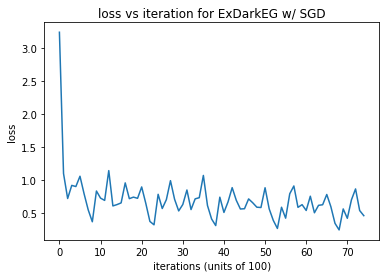

In [11]:
x = np.arange(len(losslist))
plt.plot(x,losslist)
plt.title('loss vs iteration for {} w/ {}'.format(root_folder, optim))
plt.ylabel('loss')
plt.xlabel('iterations (units of 100)');

In [12]:
l = np.array(losslist)
arrname='{}_{}_loss.npy'.format(root_folder,optim)
np.save('./torchsaves/losses/{}'.format(arrname),l)

# Get Test Metric

In [25]:
def get_predicted_boxes(output, score_thresh=0.8):
    '''
    takes in output of model and returns predicted boxes with scores > score_thresh
    
    Args:
        output: a list containing 1 dictionary (model predictions)
    '''
    predicted_list = []
    
    for label_dict in output:
        predicted = {'boxes':[],'labels':[],'scores':[]}
        s = label_dict['scores']
        for i in range(len(s)):
            if s[i] > score_thresh:
                predicted['boxes'].append(label_dict['boxes'][i].tolist())
                predicted['labels'].append(label_dict['labels'][i].tolist())
                predicted['scores'].append(s[i].tolist())
            else:
                #scores should be sorted so we just stop checking after reaching the first elem<0.8
                break
        predicted['boxes'] = torch.tensor(predicted['boxes'])
        predicted['labels'] = torch.tensor(predicted['labels'])
        predicted['scores'] = torch.tensor(predicted['scores'])
        predicted_list.append(predicted)
    return predicted_list

In [15]:
model.eval()

metric = MeanAveragePrecision()

for i in range(len(dataset_test)):
    img, truth = dataset_test[i]
    out = model(img.unsqueeze(dim=0).to(device))
    predictions = get_predicted_boxes(out)
    metric.update(predictions, [truth])

pprint(metric.compute())

{'map': tensor(0.3069),
 'map_50': tensor(0.5304),
 'map_75': tensor(0.3299),
 'map_large': tensor(0.3780),
 'map_medium': tensor(0.1578),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.0466),
 'mar_1': tensor(0.2857),
 'mar_10': tensor(0.3623),
 'mar_100': tensor(0.3623),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.4488),
 'mar_medium': tensor(0.1975),
 'mar_small': tensor(0.0482)}


# Take a look at model output

In [15]:
c = 0
num_to_class = {}
for classname in os.listdir(img_root): #'./ExDark'
    num_to_class[c] = classname
    c += 1

In [19]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [20]:
def predict_box(img, model, device=None):
    '''
    Args:
        img: image to do detection on
        model: object detection model
        device: use gpu or cpu
        
    Returns:
        img_bgr: cv2 array of img with boxes drawn on it
    '''
    output = model([img.to(device)])
    np_img = img.numpy()
    np_img = np.transpose(np_img,(1,2,0))

    #get predicted bounding boxes with score > 0.8
    predicted = {'boxes':[],'labels':[],'scores':[]}
    for label_dict in output:
        s = label_dict['scores']
        for i in range(len(s)):
            if s[i] > 0.8:
                predicted['boxes'].append(label_dict['boxes'][i].tolist())
                predicted['labels'].append(label_dict['labels'][i].tolist())
                predicted['scores'].append(s[i].tolist())
            else:
                #scores should be sorted so we just stop checking after reaching the first elem<0.8
                break

    #plot image with predicted bounding boxes
    import cv2
    color=(255,0,0)
    thickness=2
    r,g,b = cv2.split(np_img)
    img_bgr = cv2.merge([r,g,b])
    for i in range(len(predicted['boxes'])):
        xmin,ymin,xmax,ymax = predicted['boxes'][i]
        start_point = (int(xmin),int(ymin))
        end_point = (int(xmax),int(ymax))
        img_bgr = cv2.rectangle(img_bgr, start_point, end_point, color, thickness)
        l = predicted['labels'][i]
#         classname = num_to_class[l]
        classname = COCO_INSTANCE_CATEGORY_NAMES[l]
        img_bgr = cv2.putText(img_bgr,classname,(int(xmin),int(ymin)-10),cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
#     plt.imshow(img_bgr);
    return img_bgr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


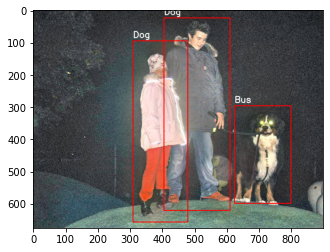

In [31]:
#we moved dog/2015_05590.jpg to its own folder TEST_IMAGE for image comparisons
img_path = './TEST_IMAGE/{}/2015_05590.jpg'.format(root_folder)
image = Image.open(img_path).convert("RGB")
image = input_transform(image)
image = image.to(dtype=torch.float32)
res = predict_box(image, model, device)
plt.imshow(res);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


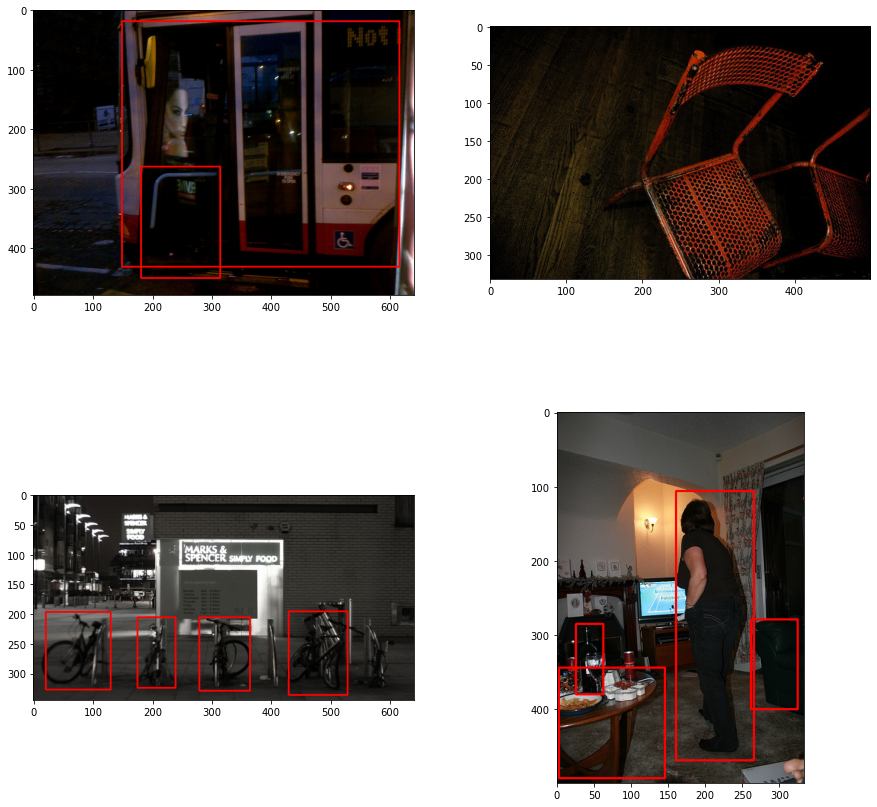

In [23]:
fig, axs = plt.subplots(2,2,figsize=(15,15))

for i in range(4):
#     ind = np.random.randint(0,len(dataset_test))
    test_img, _ = dataset_test[i]
    result = predict_box(test_img, model, device)
    x,y = np.unravel_index(i,(2,2))
    axs[x,y].imshow(result)

# Load Saved Model

run these cells before continuing any training or testing to get back to where you left off

In [6]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 13  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.002)

input_transform = T.Compose([T.ToTensor()])

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /tmp/xdg-cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

In [7]:
# model.load_state_dict(torch.load('./torchsaves/{}/model_epoch5.pt'.format(root_folder)))
# optimizer.load_state_dict(torch.load('./torchsaves/{}/optimizer_epoch5.pt'.format(root_folder)))

# model.load_state_dict(torch.load('./torchsaves/previous_saves/ExDarkLIME_SGDoptim/model_epoch9.pt'))
model.load_state_dict(torch.load('./torchsaves/ExDarkLIME_Adam/model_epoch4.pt'))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


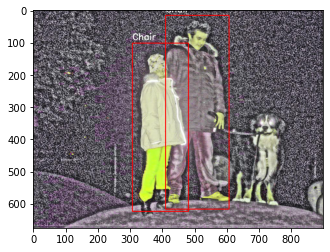

In [10]:
#we moved dog/2015_05590.jpg to its own folder TEST_IMAGE for image comparisons
model.eval()
# img_path = './TEST_IMAGE/{}/2015_05590.jpg'.format(root_folder)
# img_path = './TEST_IMAGE/{}/2015_05590.jpg'.format('ExDarkLIME')
img_path = './testimg.jpg'
image = Image.open(img_path).convert("RGB")
image = input_transform(image)
image = image.to(dtype=torch.float32)
res = predict_box(image, model, device)
plt.imshow(res);

# Using pretrained faster r-cnn model

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True,trainable_backbone_layers=0)

model.to(device)

model.eval()

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /tmp/xdg-cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): ConvNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): Seque

In [5]:
def predict_box(img, model, thresh=0.8, device=None):
    '''
    Args:
        img: image to do detection on
        model: object detection model
        device: use gpu or cpu
        
    Returns:
        img_bgr: cv2 array of img with boxes drawn on it
    '''
    output = model([img.to(device)])
    np_img = img.numpy()
    np_img = np.transpose(np_img,(1,2,0))

    #get predicted bounding boxes with score > 0.8
    predicted = {'boxes':[],'labels':[],'scores':[]}
    for label_dict in output:
        s = label_dict['scores']
        for i in range(len(s)):
            if s[i] > thresh:
                predicted['boxes'].append(label_dict['boxes'][i].tolist())
                predicted['labels'].append(label_dict['labels'][i].tolist())
                predicted['scores'].append(s[i].tolist())
            else:
                #scores should be sorted so we just stop checking after reaching the first elem<0.8
                break

    #plot image with predicted bounding boxes
    import cv2
    color=(255,0,0)
    thickness=2
    r,g,b = cv2.split(np_img)
    img_bgr = cv2.merge([r,g,b])
    for i in range(len(predicted['boxes'])):
        xmin,ymin,xmax,ymax = predicted['boxes'][i]
        start_point = (int(xmin),int(ymin))
        end_point = (int(xmax),int(ymax))
        img_bgr = cv2.rectangle(img_bgr, start_point, end_point, color, thickness)
        l = predicted['labels'][i]
#         classname = num_to_class[l]
        classname = COCO_INSTANCE_CATEGORY_NAMES[l]
        img_bgr = cv2.putText(img_bgr,classname,(int(xmin),int(ymin)-10),cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
#     plt.imshow(img_bgr);
    return img_bgr

In [6]:
input_transform = T.Compose([T.ToTensor()])

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


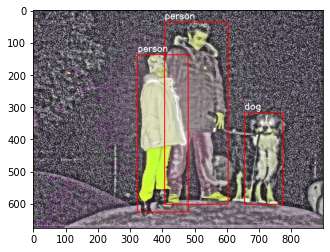

In [10]:
img_path = './testimg.jpg'
image = Image.open(img_path).convert("RGB")
image = input_transform(image)
image = image.to(dtype=torch.float32)
res = predict_box(image, model, device)
plt.imshow(res);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


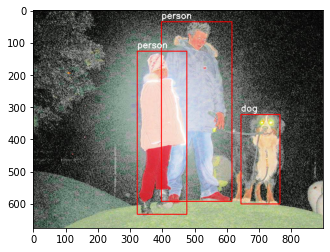

In [14]:
img_path = './testimg2.jpg'
image = Image.open(img_path).convert("RGB")
image = input_transform(image)
image = image.to(dtype=torch.float32)
res = predict_box(image, model, thresh=0.9,device)
plt.imshow(res);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


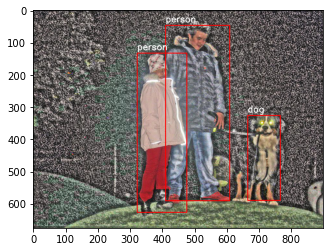

In [22]:
img_path = './testimg3.jpg'
image = Image.open(img_path).convert("RGB")
image = input_transform(image)
image = image.to(dtype=torch.float32)
res = predict_box(image, model, 0.9,device)
plt.imshow(res);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


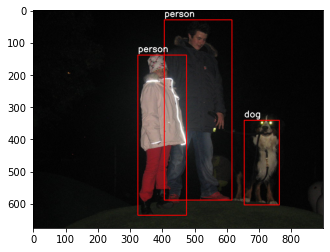

In [20]:
img_path = './TEST_IMAGE/ExDark/2015_05590.jpg'
image = Image.open(img_path).convert("RGB")
image = input_transform(image)
image = image.to(dtype=torch.float32)
res = predict_box(image, model, 0.9,device)
plt.imshow(res);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


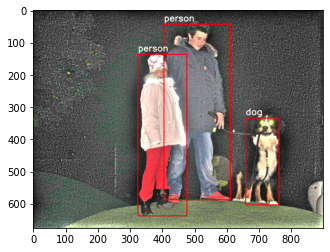

In [23]:
img_path = './TEST_IMAGE/ExDarkLIME/2015_05590.jpg'
image = Image.open(img_path).convert("RGB")
image = input_transform(image)
image = image.to(dtype=torch.float32)
res = predict_box(image, model, 0.9,device)
plt.imshow(res);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


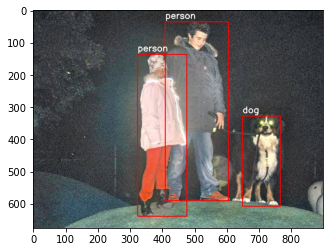

In [13]:
img_path = './TEST_IMAGE/ExDarkEG/2015_05590.jpg'
image = Image.open(img_path).convert("RGB")
image = input_transform(image)
image = image.to(dtype=torch.float32)
res = predict_box(image, model, device)
plt.imshow(res);

In [7]:
boxes = []
labels = []
target_path = './TEST_IMAGE/2015_05590.jpg.txt'
with open(target_path,'r') as f:
    for line in f:
        if line[0] == '%':
            continue
        else:
            line = line.split()
            classlabel = line[0]
            if classlabel == 'Dog':
                labels.append(19)
            elif classlabel == 'People':
                labels.append(1)
#             labels.append(self.class_to_num[classlabel])
            xmin = int(line[1])
            ymin = int(line[2])
            xmax = xmin + int(line[3])
            ymax = ymin + int(line[4])
            boxes.append([xmin, ymin, xmax, ymax]) #bounding box coords

assert len(boxes) == len(labels)

#turn everything into a torch.Tensor
boxes = torch.as_tensor(boxes, dtype=torch.float32)
labels = torch.as_tensor(labels, dtype=torch.int64)

target = {}
target['boxes'] = boxes
target['labels'] = labels

In [8]:
target

{'boxes': tensor([[600., 302., 813., 614.],
         [413.,  36., 615., 605.],
         [293., 114., 463., 640.]]),
 'labels': tensor([19,  1,  1])}

In [32]:
model.eval()

metric = MeanAveragePrecision()

img_path = ['./testimg.jpg','./TEST_IMAGE/ExDark/2015_05590.jpg',
            './TEST_IMAGE/ExDarkEG/2015_05590.jpg','./TEST_IMAGE/ExDarkLIME/2015_05590.jpg',
           './testimg.jpg','./testimg2.jpg','./testimg3.jpg']

for i in img_path:
    image = Image.open(i).convert("RGB")
    image = input_transform(image)
    image = image.to(dtype=torch.float32)
    out = model(image.unsqueeze(dim=0).to(device))
    predictions = get_predicted_boxes(out)
    metric.update(predictions, [target])

pprint(metric.compute())

{'map': tensor(0.3289),
 'map_50': tensor(0.5000),
 'map_75': tensor(0.2158),
 'map_large': tensor(0.3289),
 'map_medium': tensor(-1.),
 'map_per_class': tensor(-1.),
 'map_small': tensor(-1.),
 'mar_1': tensor(0.2250),
 'mar_10': tensor(0.3429),
 'mar_100': tensor(0.3429),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.3429),
 'mar_medium': tensor(-1.),
 'mar_small': tensor(-1.)}
